# Exploratory Data Analysis (EDA)

This notebook explores the CREMA-D speech dataset to understand
audio characteristics and vocal patterns related to stress.
The insights from this analysis guide feature selection and model design.


In [ ]:
import os
import librosa
import soundfile as sf
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set_style("whitegrid")


## Dataset Overview

CREMA-D is a labeled emotional speech dataset containing audio recordings
from multiple speakers. Each file encodes emotion and intensity in its filename.


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/dataset/CREMA-D/AudioWAV"

files = [f for f in os.listdir(DATASET_PATH) if f.endswith(".wav")]
print("Total audio files:", len(files))


Total audio files: 7442


## Stress Label Construction

CREMA-D does not provide direct stress labels.
Emotions are mapped into three stress categories:
Low, Medium, and High stress.

## Stress Label Mapping

Stress levels are derived using both **emotion category** and **intensity**
to better approximate real-world vocal stress.



In [ ]:
def map_stress(emotion, intensity):
    if emotion == "NEU":
        return "low"

    if emotion == "HAP" and intensity in ["LO", "MD"]:
        return "low"

    if emotion in ["SAD", "DIS"] and intensity in ["LO", "MD"]:
        return "moderate"

    if emotion in ["ANG", "FEA"] and intensity in ["MD", "HI"]:
        return "high"

    if intensity == "HI":
        return "high"

    return "moderate"


In [ ]:
def parse_filename(fname):
    parts = fname.replace(".wav", "").split("_")
    emotion = parts[2]
    intensity = parts[3]
    return emotion, intensity

df = pd.DataFrame({
    "file": files,
    "emotion": [parse_filename(f)[0] for f in files],
    "intensity": [parse_filename(f)[1] for f in files]
})

df["stress"] = df.apply(
    lambda row: map_stress(row["emotion"], row["intensity"]),
    axis=1
)

df.head()


,file,emotion,intensity,stress
0,1079_TIE_FEA_XX.wav,FEA,XX,moderate
1,1079_TIE_HAP_XX.wav,HAP,XX,moderate
2,1079_TIE_NEU_XX.wav,NEU,XX,low
3,1079_TIE_SAD_XX.wav,SAD,XX,moderate
4,1079_TSI_ANG_XX.wav,ANG,XX,moderate


## Stress Class Distribution

This visualization checks for class imbalance in the stress labels.


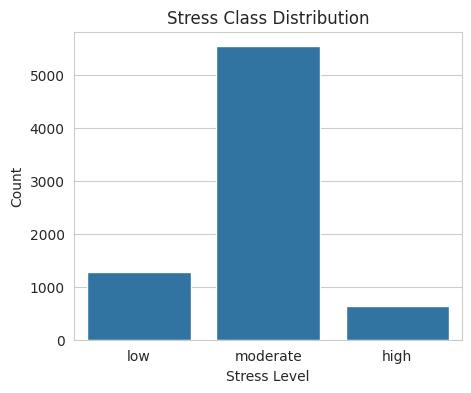

,count
stress,
moderate,5536
low,1269
high,637


In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(
    data=df,
    x="stress",
    order=["low", "moderate", "high"]
)
plt.title("Stress Class Distribution")
plt.xlabel("Stress Level")
plt.ylabel("Count")
plt.show()

df["stress"].value_counts()


There is a clear imbalance, with moderate stress dominating the dataset.  
During model training, this class imbalance will be addressed using appropriate techniques
(e.g., weighted loss or data augmentation) to ensure the model learns effectively
across all stress levels.


## Audio Duration Analysis

Understanding audio duration helps decide window sizes
and padding strategies for feature extraction.


Processing audio files: 100%|██████████| 7442/7442 [08:46<00:00, 14.14it/s]


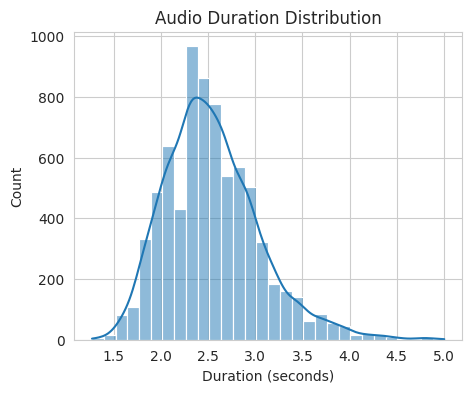

count    7442.000000
mean        2.542884
std         0.505979
min         1.267937
25%         2.202187
50%         2.502500
75%         2.836187
max         5.005000
Name: duration_sec, dtype: float64


In [ ]:

durations = []
for f in tqdm(files, desc="Processing audio files"):
    info = sf.info(os.path.join(DATASET_PATH, f))
    durations.append(info.duration)

df = pd.DataFrame({"duration_sec": durations})

# Plot histogram
plt.figure(figsize=(5,4))
sns.histplot(df["duration_sec"], bins=30, kde=True)
plt.xlabel("Duration (seconds)")
plt.title("Audio Duration Distribution")
plt.show()

# Summary stats
print(df["duration_sec"].describe())


## Sampling Rate Analysis

Sampling rate consistency is examined to ensure
uniform feature extraction.


In [ ]:
sampling_rates = []
for f in files[:200]:
    info = sf.info(os.path.join(DATASET_PATH, f))
    sampling_rates.append(info.samplerate)

pd.Series(sampling_rates).value_counts()


,count
16000,200


## Noise and Energy Characteristics

RMS energy and zero-crossing rate are used
to approximate noise and vocal intensity.


Extracting noise features: 100%|██████████| 300/300 [00:02<00:00, 133.58it/s]


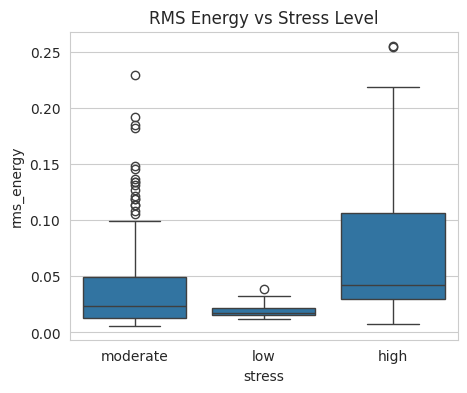

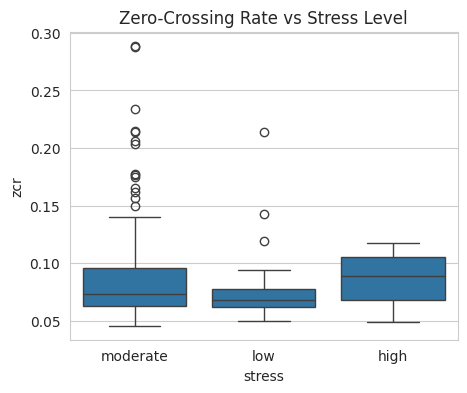

In [ ]:


def extract_noise_features(file):

    y, sr = sf.read(os.path.join(DATASET_PATH, file))
    # RMS energy (mean square root of amplitude)
    rms_energy = np.sqrt(np.mean(y**2))
    # Zero-crossing rate (sign changes)
    zcr = np.mean(np.abs(np.diff(np.sign(y)))) / 2
    return {"rms_energy": rms_energy, "zcr": zcr}


temp_df_for_sampling = pd.DataFrame({
    "file": files,
    "emotion": [parse_filename(f)[0] for f in files],
    "intensity": [parse_filename(f)[1] for f in files]
})
temp_df_for_sampling["stress"] = temp_df_for_sampling.apply(
    lambda row: map_stress(row["emotion"], row["intensity"]),
    axis=1
)

sample_entries = temp_df_for_sampling.sample(300, random_state=42)
sample_files = sample_entries["file"]

noise_features = [
    extract_noise_features(f) for f in tqdm(sample_files, desc="Extracting noise features")
]

# Build DataFrame for noise features
noise_df = pd.DataFrame(noise_features)
# Assign stress directly from the sampled entries
noise_df["stress"] = sample_entries["stress"].reset_index(drop=True)

plt.figure(figsize=(5,4))
sns.boxplot(data=noise_df, x="stress", y="rms_energy")
plt.title("RMS Energy vs Stress Level")
plt.show()


plt.figure(figsize=(5,4))
sns.boxplot(data=noise_df, x="stress", y="zcr")
plt.title("Zero-Crossing Rate vs Stress Level")
plt.show()



RMS energy increases consistently from low to high stress levels, indicating higher vocal intensity under stress..Zero Crossing Rate (ZCR) shows a weak but consistent increase from low to high stress levels. However, substantial overlap across classes indicates that ZCR alone is insufficient for robust stress discrimination.

## Waveform Visualization

Waveforms are visualized to inspect amplitude variations
across stress levels.


Plotting waveforms:   0%|          | 0/3 [00:00<?, ?it/s]

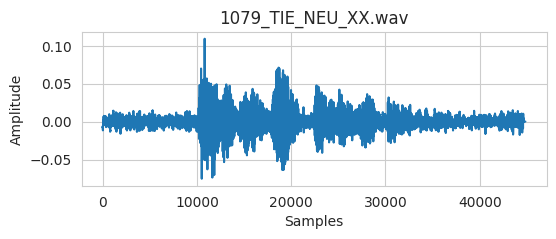

Plotting waveforms:  33%|███▎      | 1/3 [00:00<00:00,  5.34it/s]

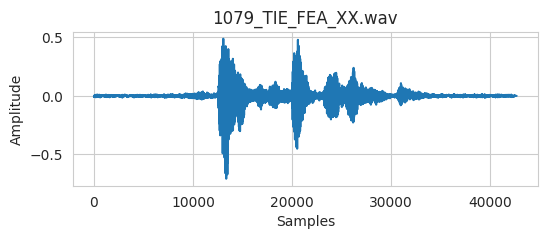

Plotting waveforms:  67%|██████▋   | 2/3 [00:00<00:00,  6.30it/s]

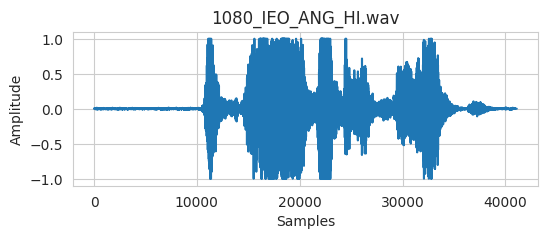

Plotting waveforms: 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]


In [ ]:


def plot_waveform(file):

    y, sr = sf.read(os.path.join(DATASET_PATH, file))
    plt.figure(figsize=(6,2))
    plt.plot(y)
    plt.title(file)
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.show()


temp_df_for_plotting = pd.DataFrame({
    "file": files,
    "emotion": [parse_filename(f)[0] for f in files],
    "intensity": [parse_filename(f)[1] for f in files]
})
temp_df_for_plotting["stress"] = temp_df_for_plotting.apply(
    lambda row: map_stress(row["emotion"], row["intensity"]),
    axis=1
)

for stress_level in tqdm(["low", "moderate", "high"], desc="Plotting waveforms"):
    sample = temp_df_for_plotting[temp_df_for_plotting["stress"] == stress_level].iloc[0]["file"]
    plot_waveform(sample)


## Spectrogram Visualization

Spectrograms reveal time–frequency patterns
associated with stress.


Plotting spectrograms:   0%|          | 0/3 [00:00<?, ?it/s]

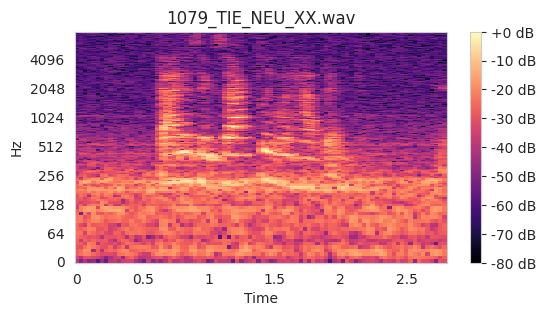

Plotting spectrograms:  33%|███▎      | 1/3 [00:00<00:00,  3.21it/s]

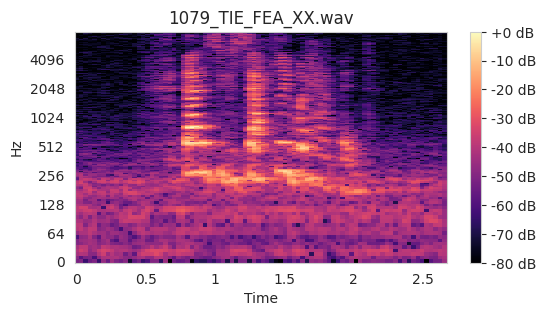

Plotting spectrograms:  67%|██████▋   | 2/3 [00:00<00:00,  3.03it/s]

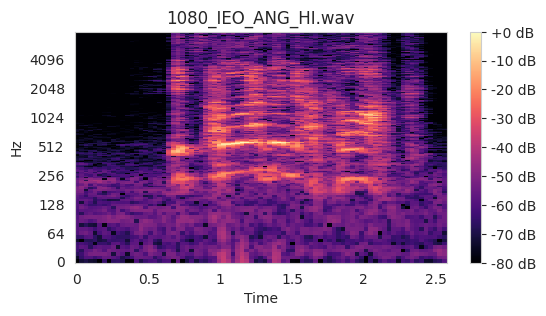

Plotting spectrograms: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


In [ ]:
def plot_spectrogram(file):
    y, sr = sf.read(os.path.join(DATASET_PATH, file))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(6,3))
    librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title(file)
    plt.show()

temp_df_for_plotting = pd.DataFrame({
    "file": files,
    "emotion": [parse_filename(f)[0] for f in files],
    "intensity": [parse_filename(f)[1] for f in files]
})
temp_df_for_plotting["stress"] = temp_df_for_plotting.apply(
    lambda row: map_stress(row["emotion"], row["intensity"]),
    axis=1
)

for stress_level in tqdm(["low", "moderate", "high"], desc="Plotting spectrograms"):
    sample = temp_df_for_plotting[temp_df_for_plotting["stress"] == stress_level].iloc[0]["file"]
    plot_spectrogram(sample)


In [ ]:
data = []

for file in os.listdir(DATASET_PATH):
    if file.endswith(".wav"):
        parts = file.replace(".wav", "").split("_")
        emotion = parts[2]
        intensity = parts[3]

        stress = map_to_stress(emotion, intensity)

        data.append({
            "path": os.path.join(DATASET_PATH, file),
            "stress": stress
        })

df = pd.DataFrame(data)
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
df.to_csv(SAVE_PATH, index=False)
df["stress"].value_counts()


Class distribution:
stress
moderate    5536
low         1269
high         637
Name: count, dtype: int64


100%|██████████| 7442/7442 [05:14<00:00, 23.63it/s]



Feature dataframe shape: (7442, 29)

=== Mel Spectrogram Statistics ===
           mel_mean              mel_std          
               mean       std       mean       std
stress                                            
high     -31.275937  6.816756  17.088974  1.306067
low      -35.965377  2.360443  16.274799  0.723359
moderate -34.246377  5.070751  16.555414  1.033007

=== MFCC Mean Statistics ===
          mfcc1_mean  mfcc2_mean  mfcc3_mean  mfcc4_mean  mfcc5_mean  \
stress                                                                 
high     -353.846837  121.956401    0.709460   40.676909  -13.632530   
low      -406.901786  137.282784    9.954306   52.403146  -11.240400   
moderate -387.453524  130.931863    7.350996   50.743398  -11.574012   

          mfcc6_mean  mfcc7_mean  mfcc8_mean  mfcc9_mean  mfcc10_mean  \
stress                                                                  
high       19.052606  -11.730640    6.691184  -12.202434     2.925833   
low        

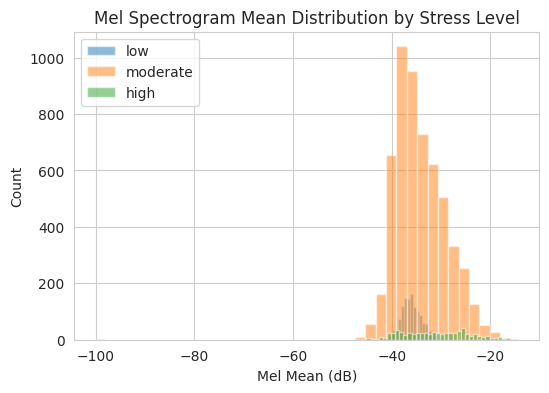

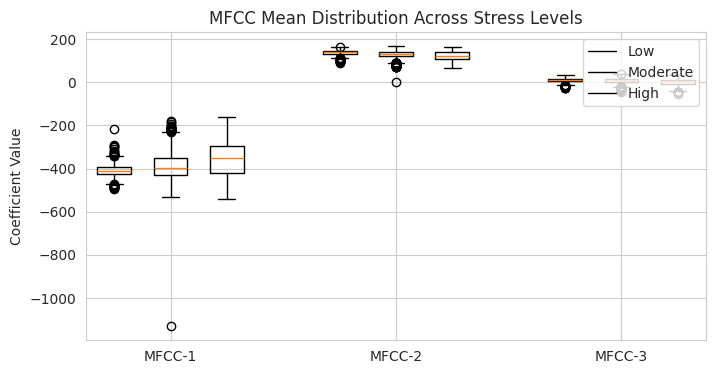

In [ ]:


metadata_path = "/content/drive/MyDrive/projects/voice_stress_analysis/data/cremad_metadata.csv"
df = pd.read_csv(metadata_path)

print("Class distribution:")
print(df["stress"].value_counts())

# -----------------------------
# Feature extraction
# -----------------------------
def extract_features(audio_path, sr=22050, n_mfcc=13):
    try:
        y, file_sr = sf.read(audio_path)
        if file_sr != sr:
            y = librosa.resample(y, orig_sr=file_sr, target_sr=sr)

        # Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel)

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        return {
            "mel_mean": mel_db.mean(),
            "mel_std": mel_db.std(),
            "mfcc_mean": mfcc.mean(axis=1),
            "mfcc_std": mfcc.std(axis=1)
        }

    except Exception:
        return None


records = []

for _, row in tqdm(df.iterrows(), total=len(df)):

    feats = extract_features(row["path"])
    if feats is None:
        continue

    rec = {
        "stress": row["stress"],
        "mel_mean": feats["mel_mean"],
        "mel_std": feats["mel_std"]
    }

    for i in range(len(feats["mfcc_mean"])):
        rec[f"mfcc{i+1}_mean"] = feats["mfcc_mean"][i]
        rec[f"mfcc{i+1}_std"] = feats["mfcc_std"][i]

    records.append(rec)

features_df = pd.DataFrame(records)

print("\nFeature dataframe shape:", features_df.shape)

# -----------------------------
# Statistical summaries (TABLES)
# -----------------------------
print("\n=== Mel Spectrogram Statistics ===")
mel_stats = features_df.groupby("stress")[["mel_mean", "mel_std"]].agg(["mean", "std"])
print(mel_stats)

print("\n=== MFCC Mean Statistics ===")
mfcc_mean_cols = [c for c in features_df.columns if "mfcc" in c and "mean" in c]
mfcc_mean_stats = features_df.groupby("stress")[mfcc_mean_cols].mean()
print(mfcc_mean_stats)

print("\n=== MFCC Std Statistics ===")
mfcc_std_cols = [c for c in features_df.columns if "mfcc" in c and "std" in c]
mfcc_std_stats = features_df.groupby("stress")[mfcc_std_cols].mean()
print(mfcc_std_stats)

# -----------------------------
# Visualization: Mel Spectrogram spread
# -----------------------------
plt.figure(figsize=(6,4))
for stress in ["low", "moderate", "high"]:
    subset = features_df[features_df["stress"] == stress]
    plt.hist(subset["mel_mean"], bins=40, alpha=0.5, label=stress)

plt.legend()
plt.title("Mel Spectrogram Mean Distribution by Stress Level")
plt.xlabel("Mel Mean (dB)")
plt.ylabel("Count")
plt.show()

# -----------------------------
# Visualization: MFCC spread (MFCC 1–3)
# -----------------------------
mfccs_to_plot = ["mfcc1_mean", "mfcc2_mean", "mfcc3_mean"]

plt.figure(figsize=(8,4))
positions = [1,2,3]

for i, mfcc in enumerate(mfccs_to_plot):
    data = [
        features_df[features_df["stress"] == s][mfcc]
        for s in ["low", "moderate", "high"]
    ]
    plt.boxplot(
        data,
        positions=[p + i*4 for p in positions],
        widths=0.6
    )

plt.xticks([2,6,10], ["MFCC-1", "MFCC-2", "MFCC-3"])
plt.legend(["Low", "Moderate", "High"], loc="upper right")
plt.title("MFCC Mean Distribution Across Stress Levels")
plt.ylabel("Coefficient Value")
plt.show()



Exploratory analysis shows that all audio samples fall within a short-duration speech range:

Minimum duration: ~1 second

Maximum duration: ~5 seconds

This indicates that stress-related cues must be extracted from short utterances, requiring models that can effectively learn from limited temporal context.

Sampling Rate

All audio files are recorded at a uniform sampling rate of 16 kHz.

This ensures:

No resampling artifacts

Consistent frequency resolution across samples

Suitability for speech-focused feature extraction (MFCCs, Mel spectrograms)

Modeling Implications

Fixed-duration inputs can be standardized using padding/truncation

Short audio length favors CNN-based spectro-temporal modeling over long-sequence models

16 kHz sampling captures the full speech bandwidth (0–8 kHz) relevant for stress analysis

## EDA Summary

Stress manifests through spectral energy shifts and variability

MFCC and Mel features show class-dependent distributions

RMS energy increases with stress but is excluded due to poor generalization

Dataset exhibits class imbalance, handled during training

Short audio durations motivate compact, efficient architectures.
While Mel spectrograms revealed energy concentration differences, MFCCs provided a more compact and stable representation suitable for CNN-based classification

These observations directly guided the selection of a CNN-based deep learning model using MFCC representations.